## Style Transfer Interpolation

Modified version of the https://github.com/fchollet/keras/blob/master/examples/neural_style_transfer.py neural style transfer. Rather than having one style image, we have two. We first train the network for a number of iterations to get to converge on the first image, before interpolating for the rest of the iterations between the first and the second.

Interpolation is done by having step variable that controls the weight of the loss

In [38]:
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import os
import imageio
from IPython.display import Image, display, HTML

from keras.applications import vgg16
from keras import backend as K
import requests

In [25]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [26]:
IMAGE_BASE = 'style_transfer/'

def fetch_image(url, fn=None):
    if not fn:
        fn = url.rsplit('/', 1)[-1]
    fn = IMAGE_BASE + fn
    if os.path.isfile(fn):
        return fn
    img = requests.get(url).content
    with open(fn, 'wb') as fout:
        fout.write(img)
    return fn

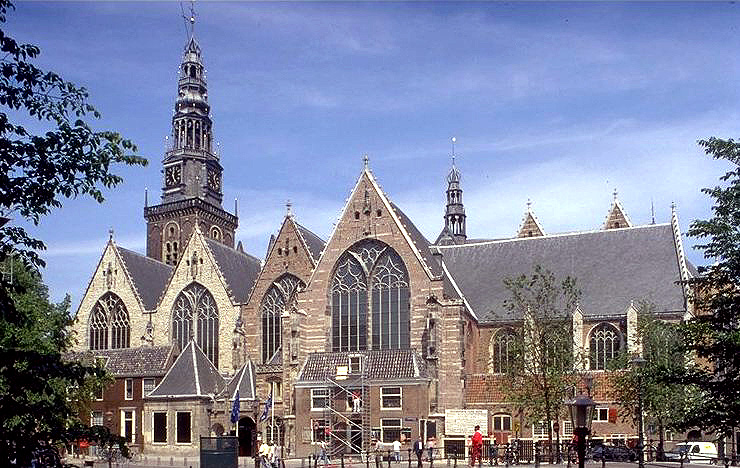

In [30]:
base_image_path = fetch_image('https://upload.wikimedia.org/wikipedia/commons/0/08/Okerk2.jpg')
style_reference_image_path_2 = fetch_image('https://upload.wikimedia.org/wikipedia/commons/9/99/Jan_van_Goyen_004b.jpg')
style_reference_image_path_1 = fetch_image('https://upload.wikimedia.org/wikipedia/commons/6/66/VanGogh-starry_night_ballance1.jpg')
Image(filename=base_image_path)

In [16]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

# warm_up is the number of iterations spend to converge towards the first image
iterations = 120
warm_up = 30

result_prefix = 'star_goyen'

In [31]:
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image_1 = K.variable(preprocess_image(style_reference_image_path_1))
style_reference_image_2 = K.variable(preprocess_image(style_reference_image_path_2))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 4 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image_1,
                              style_reference_image_2,
                              combination_image], axis=0)
input_tensor

<tf.Tensor 'concat_1:0' shape=(4, 400, 632, 3) dtype=float32>

In [7]:
# build the VGG16 network with our 4 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [8]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


In [9]:
# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [12]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict['block4_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[3, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)
step = K.placeholder()
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features_1 = layer_features[1, :, :, :]
    style_reference_features_2 = layer_features[2, :, :, :]
    combination_features = layer_features[3, :, :, :]
    sl_1 = style_loss(style_reference_features_1, combination_features) * step
    sl_2 = style_loss(style_reference_features_2, combination_features) * (1 - step)
    loss += (style_weight / len(feature_layers)) * (sl_1 + sl_2)
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image, step], outputs)

In [13]:
def eval_loss_and_grads(x, perc):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x, perc])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        self.perc = 0

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x, self.perc)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
if K.image_data_format() == 'channels_first':
    x = np.random.uniform(0, 255, (1, 3, img_nrows, img_ncols)) - 128.
else:
    x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.


frames = []
for i in range(0, iterations):
    start_time = time.time()
    if i > warm_up:
        frames.append(fname)
        evaluator.perc = float(i - warm_up) / (iterations - warm_up - 1)
    else:
        evaluator.perc = 0
    print('Start of iteration', i, evaluator.perc)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = IMAGE_BASE + result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0 0
Current loss value: 2.77769e+09
Image saved as style_transfer/star_goyen_at_iteration_0.png
Iteration 0 completed in 311s
Start of iteration 1 0
Current loss value: 2.19096e+09
Image saved as style_transfer/star_goyen_at_iteration_1.png
Iteration 1 completed in 291s
Start of iteration 2 0
Current loss value: 1.96724e+09
Image saved as style_transfer/star_goyen_at_iteration_2.png
Iteration 2 completed in 292s
Start of iteration 3 0
Current loss value: 1.84749e+09
Image saved as style_transfer/star_goyen_at_iteration_3.png
Iteration 3 completed in 292s
Start of iteration 4 0
Current loss value: 1.77549e+09
Image saved as style_transfer/star_goyen_at_iteration_4.png
Iteration 4 completed in 292s
Start of iteration 5 0
Current loss value: 1.7281e+09
Image saved as style_transfer/star_goyen_at_iteration_5.png
Iteration 5 completed in 312s
Start of iteration 6 0
Current loss value: 1.69238e+09
Image saved as style_transfer/star_goyen_at_iteration_6.png
Iteration 6 comp

In [42]:
cycled = frames + list(reversed(frames[1:-1]))
# Save them as frames into a gif 
kargs = { 'duration': 0.1 }
imageio.mimsave(IMAGE_BASE + 'animated.gif', [imageio.imread(x) for x in cycled], 'GIF', **kargs)

HTML('<img src="%s">' % (IMAGE_BASE + 'animated.gif'))